In [50]:
!pip install lightgbm

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import metrics
from collections import Counter
import shap
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc, make_scorer, precision_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [52]:
train = pd.read_csv('fraudTrain.csv', nrows=50000)

In [53]:
test = pd.read_csv('fraudTest.csv', nrows=50000)

In [54]:
train.isnull().sum()
test.isnull().sum()


Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             50000 non-null  int64  
 1   trans_date_trans_time  50000 non-null  object 
 2   cc_num                 50000 non-null  int64  
 3   merchant               50000 non-null  object 
 4   category               50000 non-null  object 
 5   amt                    50000 non-null  float64
 6   first                  50000 non-null  object 
 7   last                   50000 non-null  object 
 8   gender                 50000 non-null  object 
 9   street                 50000 non-null  object 
 10  city                   50000 non-null  object 
 11  state                  50000 non-null  object 
 12  zip                    50000 non-null  int64  
 13  lat                    50000 non-null  float64
 14  long                   50000 non-null  float64
 15  ci

In [56]:
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [57]:
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'], errors='coerce')

# Extract useful numeric features from timestamp
train['year'] = train['trans_date_trans_time'].dt.year
train['month'] = train['trans_date_trans_time'].dt.month
train['day'] = train['trans_date_trans_time'].dt.day
train['hour'] = train['trans_date_trans_time'].dt.hour

# Drop the original timestamp column
train.drop('trans_date_trans_time', axis=1, inplace=True)

In [58]:
train['dob'] = pd.to_datetime(train['dob'], errors='coerce')
train['age'] = (pd.to_datetime('today') - train['dob']).dt.days // 365
train.drop('dob', axis=1, inplace=True)


In [59]:
train.drop(columns=['Unnamed: 0','cc_num','first', 'last', 'street', 'city', 'state', 'zip', 'trans_num'],inplace=True)
train.head()


,merchant,category,amt,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud,year,month,day,hour,age
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,"Psychologist, counselling",1325376018,36.011293,-82.048315,0,2019,1,1,0,36
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,Special educational needs teacher,1325376044,49.159047,-118.186462,0,2019,1,1,0,46
2,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,Nature conservation officer,1325376051,43.150704,-112.154481,0,2019,1,1,0,63
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,Patent attorney,1325376076,47.034331,-112.561071,0,2019,1,1,0,58
4,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,Dance movement psychotherapist,1325376186,38.674999,-78.632459,0,2019,1,1,0,38


In [60]:
#use feature importance to drop more unnecessary columns
train.drop(columns=['month', 'year', 'merchant','lat','long', 'merch_lat', 'merch_long', 'day', 'age'],inplace=True)

In [61]:
train.dropna(inplace= True, ignore_index=True)


In [62]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column
categorical_columns = ['job', 'category', 'gender']
for col in categorical_columns:
    train[col] = label_encoder.fit_transform(train[col])


In [63]:
print(train.dtypes)

category       int64
amt          float64
gender         int64
city_pop       int64
job            int64
unix_time      int64
is_fraud       int64
hour           int32
dtype: object


In [64]:
labels=["Genuine","Fraud"]

fraud_or_not = train["is_fraud"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=train['is_fraud'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Genuine transactions")
fig.show()


/var/folders/8v/p7c3dl1959gcp_dhthxkrcd80000gn/T/ipykernel_55217/2838595709.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




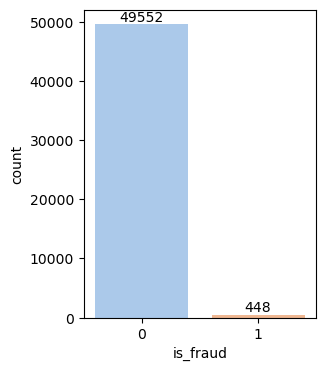

In [65]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='is_fraud',data=train,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

In [66]:
print('Genuine:', round(train['is_fraud'].value_counts()[0]/len(train) * 100,2), '% of the dataset')
print('Frauds:', round(train['is_fraud'].value_counts()[1]/len(train) * 100,2), '% of the dataset')

Genuine: 99.1 % of the dataset
Frauds: 0.9 % of the dataset


In [67]:
df = train.copy()

df.drop_duplicates(inplace=True)
print("Duplicated values dropped succesfully")

Duplicated values dropped succesfully


In [68]:
df.head()

,category,amt,gender,city_pop,job,unix_time,is_fraud,hour
0,8,4.97,0,3495,357,1325376018,0,0
1,4,107.23,0,149,412,1325376044,0,0
2,0,220.11,1,4154,295,1325376051,0,0
3,2,45.00,1,1939,316,1325376076,0,0
4,9,41.96,1,99,111,1325376186,0,0


In [69]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

In [71]:
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

smote_pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators = 100,random_state=42))
])

In [72]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
# found the best parameters using GridSearchCV so I will use them here
params = {
    'classifier__n_estimators': [200],
    'classifier__max_depth': [5],
    'classifier__min_samples_split': [2]
}


# Create Stratified K-Folds
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Create GridSearchCV
smote_rf = GridSearchCV(smote_pipeline, param_grid=params, cv=kf, scoring='recall', return_train_score=True)


In [73]:
smote_rf.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [5],
                         'classifier__min_samples_split': [2],
                         'classifier__n_estimators': [200]},
             return_train_score=True, scoring='recall')

In [74]:
print("Best Parameters:", smote_rf.best_params_)
print("Best Recall Score:", smote_rf.best_score_)

Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best Recall Score: 0.7674908424908425


In [75]:
y_pred = smote_rf.best_estimator_.predict(X_test)

In [76]:
from sklearn.metrics import recall_score

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Precision:", precision)

Accuracy: 0.9614
Recall: 0.753731343283582
F1 Score: 0.2586427656850192
Precision: 0.1561051004636785


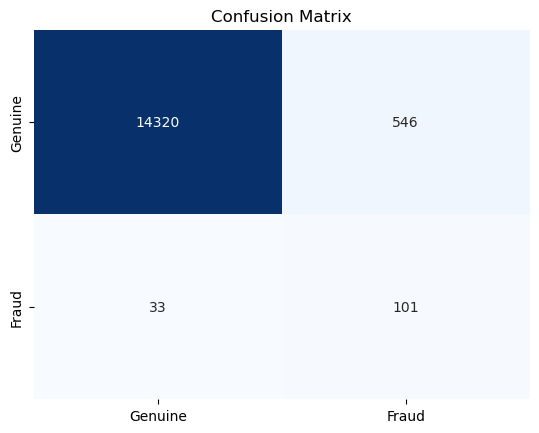

In [77]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Genuine", "Fraud"], yticklabels=["Genuine", "Fraud"])
plt.title('Confusion Matrix')
plt.show()

In [78]:
test

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,2020-07-07 23:21:45,3546897637165774,fraud_Brown-Greenholt,entertainment,12.52,Kayla,Obrien,F,7921 Robert Port Suite 343,...,31.6591,-96.8094,263,Barrister,1956-05-30,81d3aeec9e3711b113d2609c49f88bf8,1373239305,31.584684,-96.019628,0
49996,49996,2020-07-07 23:21:58,30290551782700,fraud_Lubowitz-Walter,kids_pets,48.92,John,Clarke,M,27909 Peter Motorway,...,36.8020,-87.8286,13422,Commissioning editor,1961-09-03,5d25f557780a6de915b62d176bd3b9af,1373239318,36.706261,-88.068674,0
49997,49997,2020-07-07 23:22:23,4277232699798846,fraud_Gaylord-Powlowski,home,2.12,Jennifer,Vance,F,13299 Patrick Terrace,...,46.1664,-103.7079,475,Illustrator,1955-11-10,c275c3da688e12ddb0905400dbf980f4,1373239343,46.180505,-103.241477,0
49998,49998,2020-07-07 23:22:57,4428780983793657331,fraud_White and Sons,home,246.12,Richard,Waters,M,7683 Natasha Way Apt. 945,...,42.9993,-88.2196,95015,"Therapist, occupational",1946-01-02,984d39eec8dd104fec2fac01171857f8,1373239377,42.519981,-88.398814,0


In [79]:
test['trans_date_trans_time'] = pd.to_datetime(test['trans_date_trans_time'], errors='coerce')

# Extract useful numeric features from timestamp
test['year'] = test['trans_date_trans_time'].dt.year
test['month'] = test['trans_date_trans_time'].dt.month
test['day'] = test['trans_date_trans_time'].dt.day
test['hour'] = test['trans_date_trans_time'].dt.hour

# Drop the original timestamp column
test.drop('trans_date_trans_time', axis=1, inplace=True)

In [80]:
test['dob'] = pd.to_datetime(test['dob'], errors='coerce')
test['age'] = (pd.to_datetime('today') - test['dob']).dt.days // 365
test.drop('dob', axis=1, inplace=True)

In [81]:
test.drop(columns=['Unnamed: 0','cc_num','first', 'last', 'street', 'city', 'state', 'zip', 'trans_num'],inplace=True)
test.head()

,merchant,category,amt,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud,year,month,day,hour,age
0,fraud_Kirlin and Sons,personal_care,2.86,M,33.9659,-80.9355,333497,Mechanical engineer,1371816865,33.986391,-81.200714,0,2020,6,21,12,56
1,fraud_Sporer-Keebler,personal_care,29.84,F,40.3207,-110.4360,302,"Sales professional, IT",1371816873,39.450498,-109.960431,0,2020,6,21,12,35
2,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,40.6729,-73.5365,34496,"Librarian, public",1371816893,40.495810,-74.196111,0,2020,6,21,12,54
3,fraud_Haley Group,misc_pos,60.05,M,28.5697,-80.8191,54767,Set designer,1371816915,28.812398,-80.883061,0,2020,6,21,12,37
4,fraud_Johnston-Casper,travel,3.19,M,44.2529,-85.0170,1126,Furniture designer,1371816917,44.959148,-85.884734,0,2020,6,21,12,69


In [82]:
#use feature importance to drop more unnecessary columns
test.drop(columns=['month', 'year', 'merchant','lat','long', 'merch_lat', 'merch_long', 'day', 'age'],inplace=True)

In [83]:
test.head()

,category,amt,gender,city_pop,job,unix_time,is_fraud,hour
0,personal_care,2.86,M,333497,Mechanical engineer,1371816865,0,12
1,personal_care,29.84,F,302,"Sales professional, IT",1371816873,0,12
2,health_fitness,41.28,F,34496,"Librarian, public",1371816893,0,12
3,misc_pos,60.05,M,54767,Set designer,1371816915,0,12
4,travel,3.19,M,1126,Furniture designer,1371816917,0,12


In [84]:
test.dropna(ignore_index=True)


,category,amt,gender,city_pop,job,unix_time,is_fraud,hour
0,personal_care,2.86,M,333497,Mechanical engineer,1371816865,0,12
1,personal_care,29.84,F,302,"Sales professional, IT",1371816873,0,12
2,health_fitness,41.28,F,34496,"Librarian, public",1371816893,0,12
3,misc_pos,60.05,M,54767,Set designer,1371816915,0,12
4,travel,3.19,M,1126,Furniture designer,1371816917,0,12
...,...,...,...,...,...,...,...,...
49995,entertainment,12.52,F,263,Barrister,1373239305,0,23
49996,kids_pets,48.92,M,13422,Commissioning editor,1373239318,0,23
49997,home,2.12,F,475,Illustrator,1373239343,0,23
49998,home,246.12,M,95015,"Therapist, occupational",1373239377,0,23


In [85]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column
categorical_columns = ['job', 'category', 'gender']
for col in categorical_columns:
    test[col] = label_encoder.fit_transform(test[col])

In [86]:
X_test_final = test.drop('is_fraud', axis=1)
y_test_final = test['is_fraud']

In [87]:
best_model = smote_rf.best_estimator_
y_test_pred = best_model.predict(X_test_final)

In [88]:
test_accuracy = accuracy_score(y_test_final, y_test_pred)
test_recall = recall_score(y_test_final, y_test_pred)
test_f1_score = f1_score(y_test_final, y_test_pred)
test_precision_score = precision_score(y_test_final, y_test_pred)
test_conf_matrix = confusion_matrix(y_test_final, y_test_pred)

In [89]:
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1_score)
print("Test Precision:", test_precision_score)

Test Accuracy: 0.96458
Test Recall: 0.7286432160804021
Test F1 Score: 0.14070839398350315
Test Precision: 0.07787325456498388


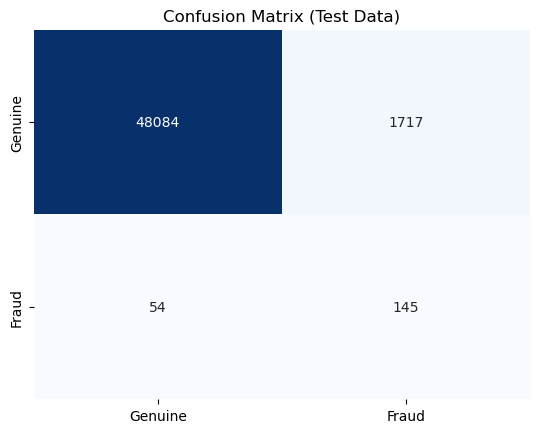

In [90]:
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Genuine", "Fraud"], yticklabels=["Genuine", "Fraud"])
plt.title('Confusion Matrix (Test Data)')
plt.show()

In [91]:
best_rf = smote_rf.best_estimator_.named_steps['classifier']
importances = best_rf.feature_importances_

# Combine feature names and their importance values
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top features
print(feature_importance_df)

     Feature  Importance
1        amt    0.671933
6       hour    0.139161
4        job    0.050359
0   category    0.049972
5  unix_time    0.038071
2     gender    0.027875
3   city_pop    0.022629


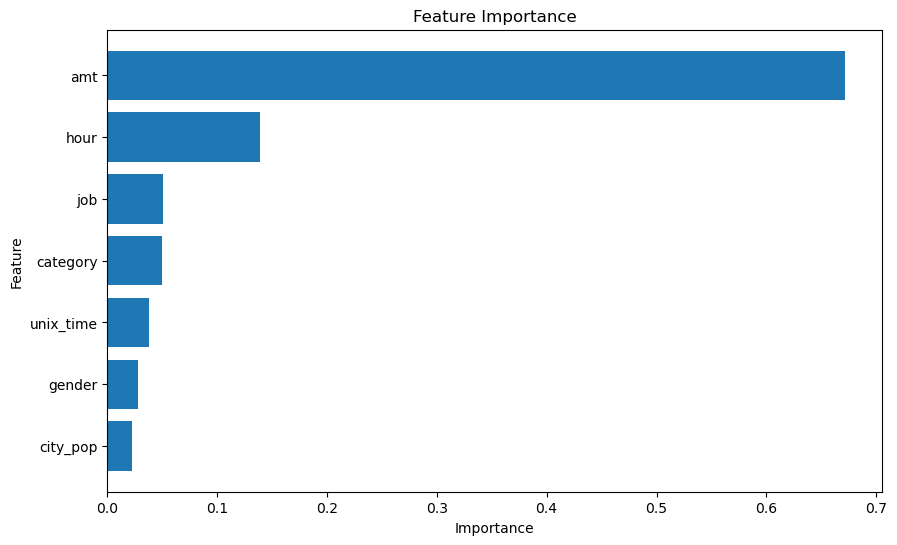

In [92]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Reverse the order for better readability
plt.show()


In [93]:
print("Test set distribution:")
print(test['is_fraud'].value_counts())


Test set distribution:
is_fraud
0    49801
1      199
Name: count, dtype: int64


In [94]:
print("Predicted class distribution:")
print(pd.Series(y_pred).value_counts())

Predicted class distribution:
0    14353
1      647
Name: count, dtype: int64
